In [7]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from keras_preprocessing import image
import random

In [11]:
p = Path('images/')
dirs = p.glob('*')

image_data = []

for folder_name in dirs:
    
    for image_path in folder_name.glob('*.jpg'):
        
        img = image.load_img(image_path,target_size=(96,96))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        
img_data = np.array(image_data, dtype='float32')/255.0   ##Normalizing the data

idx = list(range(0,808))
random.shuffle(idx)
img_data = img_data[idx]

In [12]:
print(img_data.shape)

(808, 96, 96, 3)


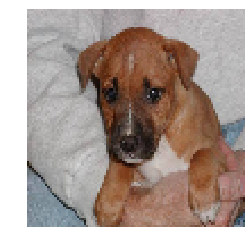

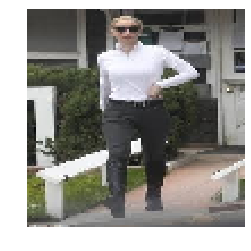

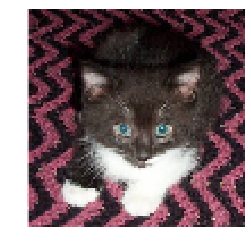

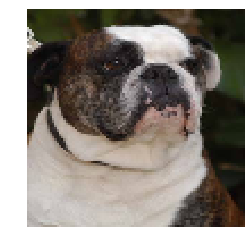

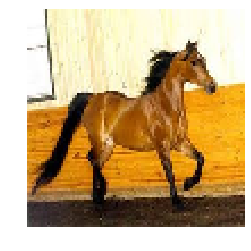

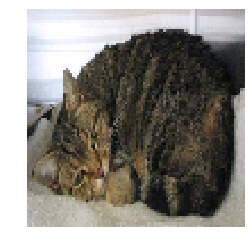

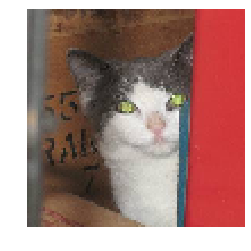

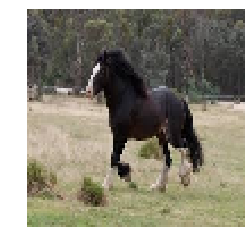

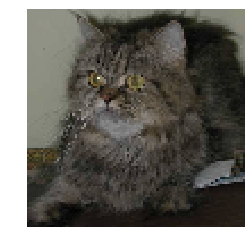

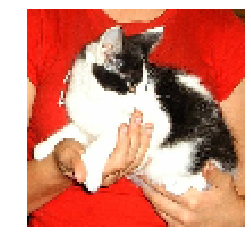

In [13]:
def drawImg(image):
    
    from matplotlib import pyplot as plt
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return

for ix in range(10):
    drawImg(img_data[ix])

In [29]:
#Noise Functions
def salt_and_pepper(image,factor):
    noise_factor = factor
    
    x_train_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

def gaussian_noise(x_train,mean,sigma,proportion):    
    x_train_noisy = []
    for i in range(x_train.shape[0]):
        image = x_train[i]
        noise = proportion*np.random.normal(mean,sigma,x_train[0].shape)
        x_train_noisy.append(image + noise)
     
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [33]:
#Adding noise to images
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = int(images.shape[0]/2)
    noise1 = salt_and_pepper(images[0:batch],0.2)
    noise2 = salt_and_pepper(images[batch:],0.4)
    
    noisy_set = []
    for data in [noise1,noise2]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)

In [34]:
#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def pair_shuffle(images,noisy_set):
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    random.shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)

In [35]:
#Getting the noisy image set
noisy_set = add_noise(img_data)
ground_truth,noisy_images = pair_shuffle(img_data,noisy_set)

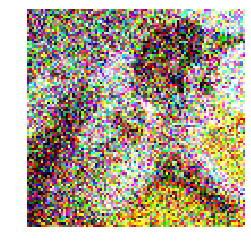

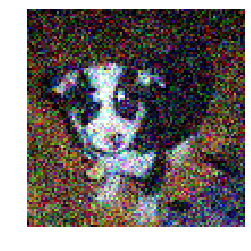

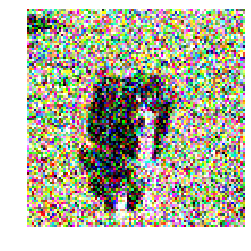

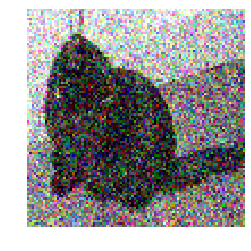

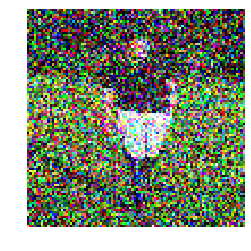

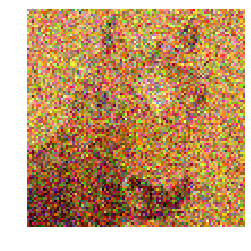

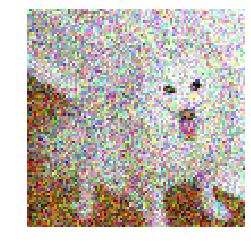

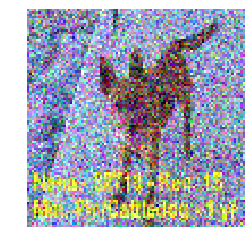

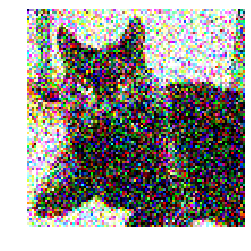

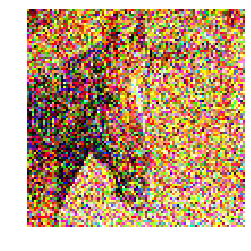

(808, 96, 96, 3)


In [36]:
for ix in range(10):
    drawImg(noisy_images[ix])
print (noisy_images.shape)

In [38]:
#Split into training and cross validation
train_size = int(ground_truth.shape[0]*0.8)
x_train = ground_truth[0:train_size]
x_train_noisy = noisy_images[0:train_size]
x_test = ground_truth[train_size:]
x_test_noisy = noisy_images[train_size:]

print(x_train_noisy.shape)
print(x_test_noisy.shape)

(646, 96, 96, 3)
(162, 96, 96, 3)


In [72]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from keras import regularizers
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

In [76]:
def get_gated_connections(gatePercentageFactor,inputLayer):
    inputs = keras.Input(tensor=ph)
    inputs._keras_history[0].is_placeholder=True
    gateFactor = Input(tensor = K.variable([gatePercentageFactor]))
    gateFactor._keras_history[0].is_placeholder=True
    fractionG = Lambda(lambda x: x[0]*x[1])([inputLayer,gateFactor])
    complement = Lambda(lambda x: x[0] - x[1])([inputLayer,fractionG])
    
    return gateFactor,fractionG,complement

#x is conv layer
#y is de-conv layer
#gf is gating factor
#fg is fractional input from gate
#c is complement ie remaining fraction from the gate
#jt joining tensor of convolution layer and previous de-conv layer 

def get_cnn_architecture(weights_path=None):
    
    input_img = Input(shape=(64,64,3))  # adapt this if using `channels_first` image data format
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    gf1,fg1,c1 = get_gated_connections(0.1,x1)
    
    x = MaxPooling2D((2, 2), padding='same')(fg1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    gf2,fg2,c2 = get_gated_connections(0.2,x2)

    x = MaxPooling2D((2, 2), padding='same')(fg2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    gf3,fg3,c3 = get_gated_connections(0.3,x3)
    
    x = MaxPooling2D((2, 2), padding='same')(x3)
    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    gf4,fg4,c4 = get_gated_connections(0.4,x4)
    
    x = MaxPooling2D((2, 2), padding='same')(x4)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(x) 
    
    x = UpSampling2D((2, 2))(x5)
    y1 = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x) 
    jt4 = Add()([y1,c4])
    x = UpSampling2D((2, 2))(jt4)
    
    y2 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) 
    jt3 = Add()([y2,c3])
    x = UpSampling2D((2, 2))(jt3)
    
    y3 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x) 
    jt2 = Add()([y3,c2])
    x = UpSampling2D((2, 2))(jt2)
    
    jt1 = Add()([x,c1])
    y4 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(jt1)
    y5 = Conv2DTranspose(3, (3, 3), activation='relu', padding='same')(y4) 
    
    layers = y5
    
    model = Model([input_img,gf1,gf2,gf3,gf4],layers)
    model.compile(optimizer='sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
    model.summary()
    
    return model

In [77]:
model = get_cnn_architecture()

NameError: name 'ph' is not defined

In [80]:
import tensorflow as tf
tf.executing_eagerly()

ph = tf.placeholder(shape=[None,2], dtype=tf.float32)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [69]:
from keras.models import InputLayer

In [ ]:
k.InputLayer